In [ ]:
!pip install pystan
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 902 kB 7.0 MB/s 
     |████████████████████████████████| 9.8 MB 37.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install arviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
import arviz as az
import arviz.labels as azl
import pystan
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from arch.bootstrap import IndependentSamplesBootstrap

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
sat = pd.read_csv('/content/gdrive/MyDrive/Thesis_data/US_data.csv')
mean_df = pd.read_csv('/content/gdrive/MyDrive/Thesis_data/sat_mean.csv')

In [ ]:
tot_mean2019 = mean_df[mean_df['year']==2019]['tot_mean'].values
tot_mean2020 = mean_df[mean_df['year']==2020]['tot_mean'].values
erw_mean2019 = mean_df[mean_df['year']==2019]['erw_mean'].values
erw_mean2020 = mean_df[mean_df['year']==2020]['erw_mean'].values
math_mean2019 = mean_df[mean_df['year']==2019]['math_mean'].values
math_mean2020 = mean_df[mean_df['year']==2020]['math_mean'].values

tot_fem2019 = mean_df[mean_df['year']==2019]['tot_fem'].values
tot_fem2020 = mean_df[mean_df['year']==2020]['tot_fem'].values
erw_fem2019 = mean_df[mean_df['year']==2019]['erw_fem'].values
erw_fem2020 = mean_df[mean_df['year']==2020]['erw_fem'].values
math_fem2019 = mean_df[mean_df['year']==2019]['math_fem'].values
math_fem2020 = mean_df[mean_df['year']==2020]['math_fem'].values

tot_male2019 = mean_df[mean_df['year']==2019]['tot_male'].values
tot_male2020 = mean_df[mean_df['year']==2020]['tot_male'].values
erw_male2019 = mean_df[mean_df['year']==2019]['erw_male'].values
erw_male2020 = mean_df[mean_df['year']==2020]['erw_male'].values
math_male2019 = mean_df[mean_df['year']==2019]['math_male'].values
math_male2020 = mean_df[mean_df['year']==2020]['math_male'].values

In [ ]:
# def standardization(arr):
#   arr = np.array(arr)
#   maxi = np.max(arr)
#   mini = np.min(arr)
#   new_arr = 100*(arr-mini)/(maxi-mini)
#   return new_arr

def standardization(arr):
  orig_x = np.array(arr)
  sortpos_x = np.argsort(orig_x)
  new_arr = []
  for i in range(len(orig_x)):
    numerator = np.where(sortpos_x == i)[0][0] + 1
    new_arr.append(100*numerator/len(orig_x))
  return new_arr

In [ ]:
tot_perc2019 = standardization(tot_mean2019)
erw_perc2019 = standardization(erw_mean2019)
math_perc2019 = standardization(math_mean2019)
tot_fem_perc2019 = standardization(tot_fem2019)
erw_fem_perc2019 = standardization(erw_fem2019)
math_fem_perc2019 = standardization(math_fem2019)
tot_male_perc2019 = standardization(tot_male2019)
erw_male_perc2019 = standardization(erw_male2019)
math_male_perc2019 = standardization(math_male2019)

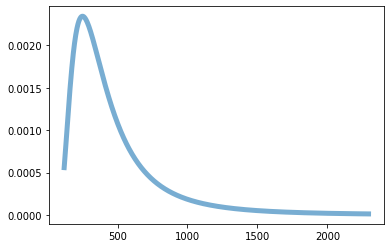

In [ ]:
from scipy.stats import invgamma
# R = invgamma.rvs(a=1, scale = 2,  size = 1000)
# plt.hist(R, density=True, alpha=0.2)
# plt.show()
x = np.linspace(invgamma.ppf(0.01, a=3, scale=1000), invgamma.ppf(0.99, a=3,scale=1000), 1000)
plt.plot(x, invgamma.pdf(x, a=3, scale=1000), lw=5, alpha=0.6, label='invgamma pdf')

(0.0, 1000.0)

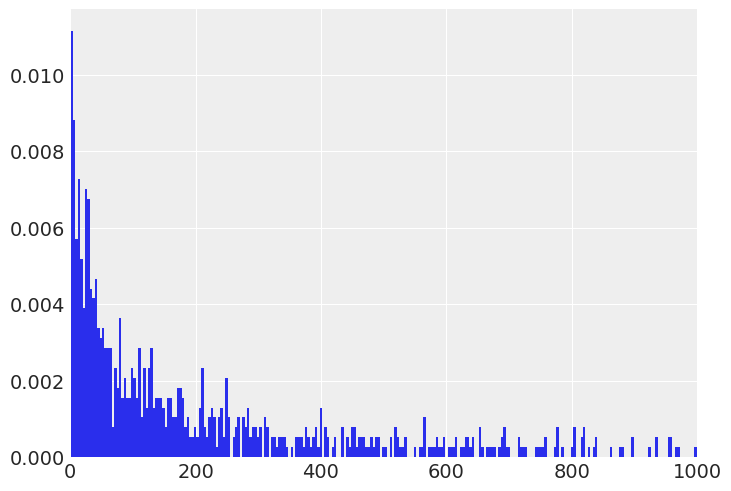

In [ ]:
plt.hist(s, 10000, density=True, align='mid')
plt.xlim(0,1000)

# Prior Predictive Checking

In [ ]:
model_prior = '''
data {
  int<lower=1> n;      
}

model {
}

generated quantities {
  real mu = normal_rng(-10, 10);
  real sigma = lognormal_rng(3,2);
  # real sigma = inv_gamma_rng(2, 600);
  real y[n];
  for (j in 1:n) y[j] = normal_rng(mu, sigma); 
}
'''

In [ ]:
prior = pystan.StanModel(model_code=model_prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_95e03774830b9b2e9cf0ba0d24e1d3a1 NOW.


In [ ]:
data = {'n': len(tot_perc2019)}
fit_prior = prior.sampling(data=data, iter=3000, chains=5, warmup=1000, thin=1, algorithm='Fixed_param', seed=22)

In [ ]:
prior_sample = np.zeros(51)

In [ ]:
for i in range(1,52):
  current_y = np.mean(fit_prior['y['+str(i)+']'])
  prior_sample[i-1] = current_y

In [ ]:
y1 = np.sort(fit_prior['y[1]'])[3000:12000]
y2 = np.sort(fit_prior['y[2]'])[3000:12000]
y3 = np.sort(fit_prior['y[3]'])[3000:12000]
y4 = np.sort(fit_prior['y[4]'])[3000:12000]

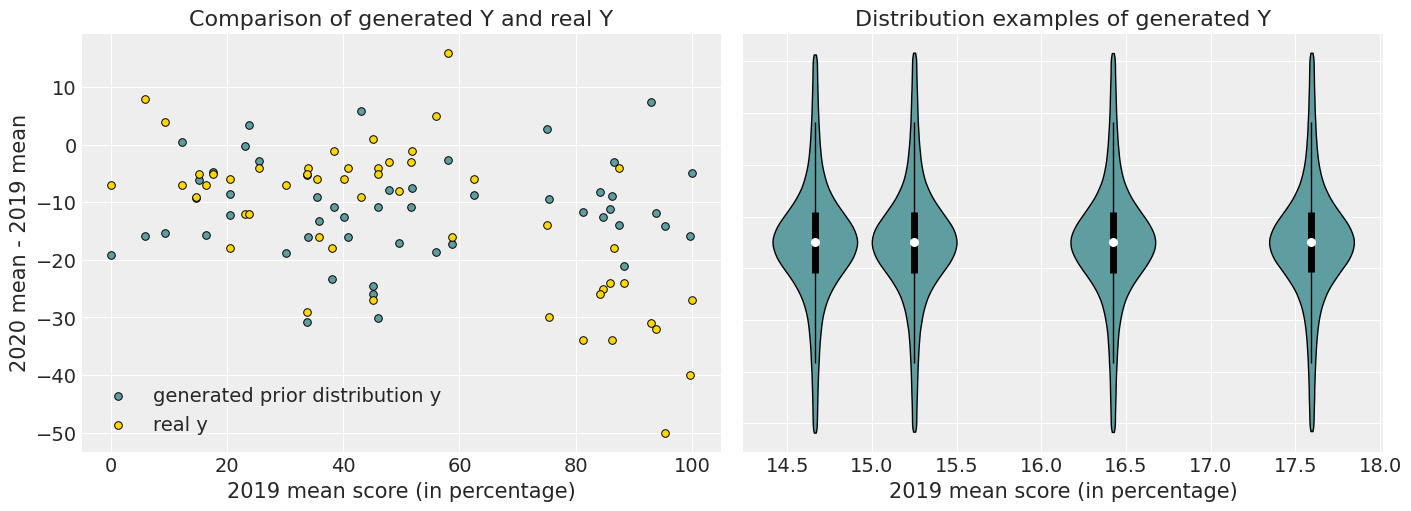

In [ ]:
violins = [y1, y2, y3, y4]

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,5))
ax0.scatter(tot_perc2019, prior_sample, color='cadetblue', edgecolor='black', s=30, linewidth=0.7, label='generated prior distribution y')
ax0.scatter(tot_perc2019, tot_mean2020-tot_mean2019, color='gold', edgecolor='black', s=30, linewidth=0.7, label='real y')
ax0.set_title('Comparison of generated Y and real Y')
ax0.legend()

def adjacent_values(vals, q1, q3):
    # print(vals)
    # print(q1)
    # print(q3)
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

parts = ax1.violinplot(violins, positions=[14.6627566, 15.24926686, 16.42228739, 17.59530792],showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('cadetblue')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(violins, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(violins, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

# inds = np.arange(1, len(medians) + 1)
inds = [14.6627566, 15.24926686, 16.42228739, 17.59530792]
ax1.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax1.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax1.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
ax1.set_title('Distribution examples of generated Y')

# set style for the axes
# labels = ['A', 'B', 'C', 'D']
# for ax in [ax1, ax2]:
#     set_axis_style(ax, labels)

# plt.subplots_adjust(bottom=0.15, wspace=0.05)
for ax in [ax0, ax1]:
    ax.set(xlabel='2019 mean score (in percentage)', ylabel='2020 mean - 2019 mean')
for ax in fig.get_axes():
    ax.label_outer()
plt.show()

# Bayes Modelling

In [ ]:
model_smallFlower = '''
data {
  int<lower=1> n;      
  vector[n] x;
  vector[n] y;
}

parameters {
  real mu_left;
  real mu_right;
  real<lower=0> sigma_left;
  real<lower=0> sigma_right;
  real<lower=50,upper=90> cutpoint;
} 

transformed parameters{
  vector[n] mu; // expected value
  vector[n] sigma; // sd value

  
  for (i in 1:n) {
    if (x[i] < cutpoint) {
      mu[i] = mu_left;
      sigma[i] = sigma_left;
    } else {
      mu[i] = mu_right;
      sigma[i] = sigma_right;
    }
  }
}

model {
  mu_left ~ normal(-10, 10);
  mu_right ~ normal(-10, 10);
  sigma_left ~ lognormal(3, 2);
  sigma_right ~ lognormal(3, 2);
  cutpoint ~ uniform(50, 90);
  y ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  vector[n] y_hat;
  for (j in 1:n) {
      log_lik[j] = normal_lpdf(y[j] | mu[j], sigma[j]);
      y_hat[j] = normal_rng(mu[j], sigma[j]);
  }
}
'''

In [ ]:
# from arviz.plots.plot_utils import xarray_var_iter
def traceplot(fit_type, density_label, trace_label, color):
  az.style.use("arviz-darkgrid")
  az.style.use(color)
  labeller = azl.MapLabeller(var_name_map={"cutpoint": density_label})
  data = az.from_pystan(
      posterior=fit_type,
      posterior_predictive='y_hat',
      observed_data=['y'],
      log_likelihood={"y": "log_lik"},
      coords={"states": np.arange(len(x))},
      dims={
          "mu": ["states"],
          "y": ["states"],
          "log_lik": ["states"],
          "y_hat": ["states"],
          "sigma": ["states"],
      },
  )
  var_names = ['cutpoint']
  # lines = list(xarray_var_iter(data.posterior[var_names].mean(dim=("chain", "draw"))))
  az.plot_trace(data, var_names=['cutpoint'], labeller=labeller);
  plt.title(trace_label,fontdict = {'fontsize' : 11})
  # plt.xlabel('hello')

In [ ]:
sm_subs = pystan.StanModel(model_code=model_smallFlower)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c7a171c6279c2781fba82e36eaf5207 NOW.


In [ ]:
# ERW total score
x = erw_perc2019
y = erw_mean2020 - erw_mean2019
data = {'n': len(x), 'x': x, 'y': y}
fit_erw = sm_subs.sampling(data=data, iter=10000, chains=10, warmup=1000, thin=1, seed=2)

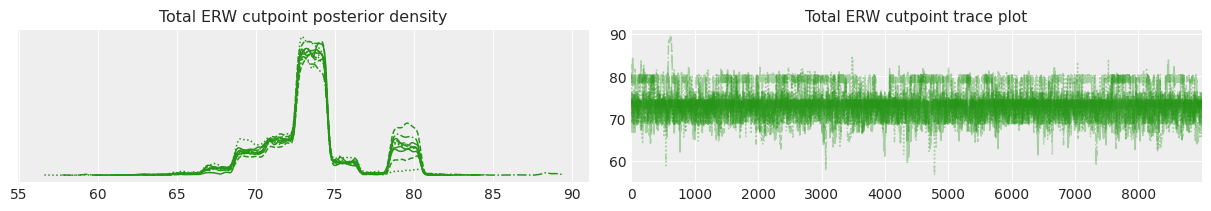

In [ ]:
traceplot(fit_erw, 'Total ERW cutpoint posterior density', 'Total ERW cutpoint trace plot', 'arviz-greenish')

In [ ]:
# ERW female score
x = erw_fem_perc2019
y = erw_fem2020 - erw_fem2019
data = {'n': len(x), 'x': x, 'y': y}
fit_erwfem = sm_subs.sampling(data=data, iter=13000, chains=10, warmup=1000, thin=1, seed=0)

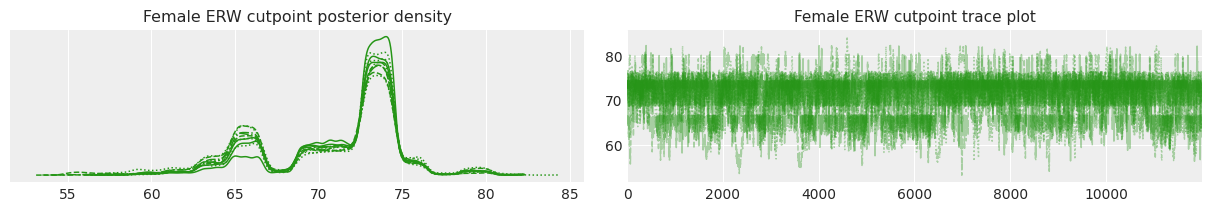

In [ ]:
traceplot(fit_erwfem, 'Female ERW cutpoint posterior density', 'Female ERW cutpoint trace plot', 'arviz-greenish')

In [ ]:
# ERW male score
x = erw_male_perc2019
y = erw_male2020 - erw_male2019
data = {'n': len(x), 'x': x, 'y': y}
fit_erwmale = sm_subs.sampling(data=data, iter=10000, chains=10, warmup=1000, thin=1, seed=2)

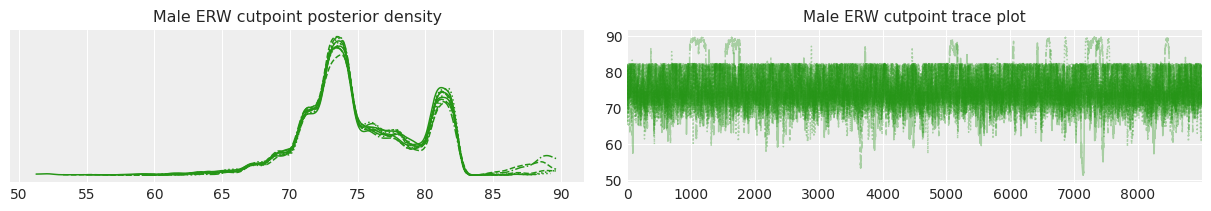

In [ ]:
traceplot(fit_erwmale,'Male ERW cutpoint posterior density', 'Male ERW cutpoint trace plot', 'arviz-greenish')

In [ ]:
# Math total score
x = math_perc2019
y = math_mean2020 - math_mean2019
data = {'n': len(x), 'x': x, 'y': y}
fit_math = sm_subs.sampling(data=data, iter=10000, chains=10, warmup=1000, thin=1, seed=2)

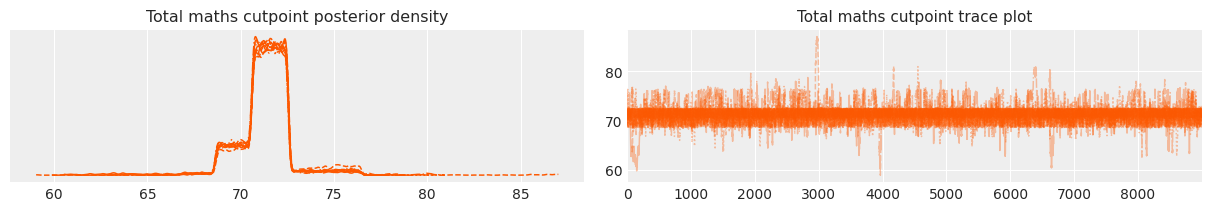

In [ ]:
traceplot(fit_math, 'Total maths cutpoint posterior density', 'Total maths cutpoint trace plot', 'arviz-orangish')

In [ ]:
# Math female score
x = math_fem_perc2019
y = math_fem2020 - math_fem2019
data = {'n': len(x), 'x': x, 'y': y}
fit_mathfem = sm_subs.sampling(data=data, iter=18000, chains=20, warmup=2000, thin=1, seed=1)

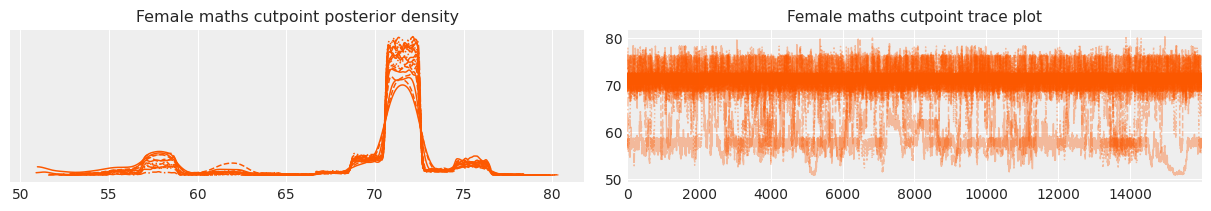

In [ ]:
traceplot(fit_mathfem, 'Female maths cutpoint posterior density', 'Female maths cutpoint trace plot', 'arviz-orangish')

In [ ]:
# print(fit_mathfem)

In [ ]:
# Math male score
x = math_male_perc2019
y = math_male2020 - math_male2019
data = {'n': len(x), 'x': x, 'y': y}
fit_mathmale = sm_subs.sampling(data=data, iter=10000, chains=10, warmup=1000, thin=1, seed=2)

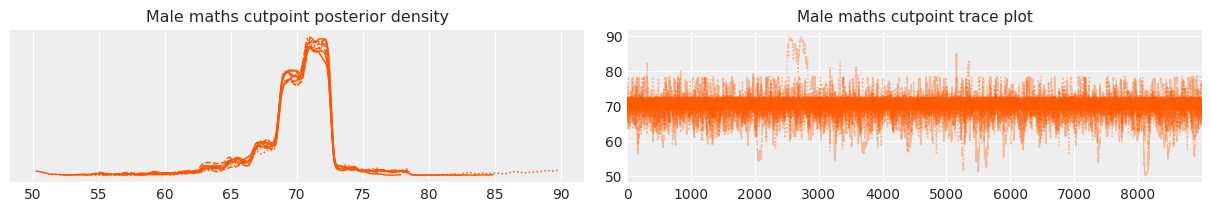

In [ ]:
traceplot(fit_mathmale, 'Male maths cutpoint posterior density', 'Male maths cutpoint trace plot', 'arviz-orangish')

In [ ]:
# linedict = {}
# linedict['clower'] = 1000 # lower bound on uniform prior distribution for c
# linedict['cupper'] = 1250
# Compile the model
# sm = pystan.StanModel(model_code=model_flower)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f222537eb519143a3fb53e28372d5729 NOW.


In [ ]:
# Total female score
x = tot_fem_perc2019
y = tot_fem2020 - tot_fem2019
data = {'n': len(x), 'x': x, 'y': y}
fit_femtot = sm_subs.sampling(data=data, iter=18000, chains=15, warmup=2000, thin=1, seed=10)

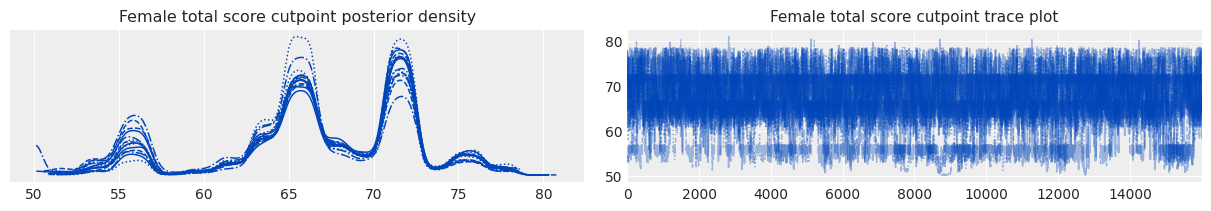

In [ ]:
traceplot(fit_femtot, 'Female total score cutpoint posterior density', 'Female total score cutpoint trace plot', 'arviz-bluish')

In [ ]:
# print(fit_femtot)

In [ ]:
# Total male score
x = tot_male_perc2019
y = tot_male2020 - tot_male2019
data = {'n': len(x), 'x': x, 'y': y}
fit_maletot = sm_subs.sampling(data=data, iter=10000, chains=10, warmup=1000, thin=1, seed=2)

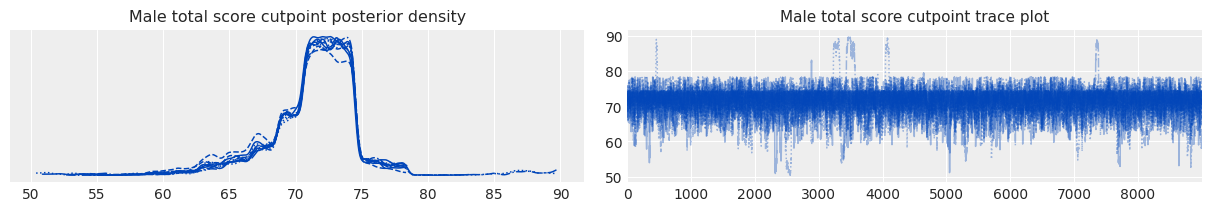

In [ ]:
traceplot(fit_maletot, 'Male total score cutpoint posterior density', 'Male total score cutpoint trace plot', 'arviz-bluish')

In [ ]:
# Total score
x = tot_perc2019
y = tot_mean2020 - tot_mean2019
data = {'n': len(x), 'x': x, 'y': y}
fit = sm_subs.sampling(data=data, iter=10000, chains=10, warmup=1000, thin=1, seed=2)

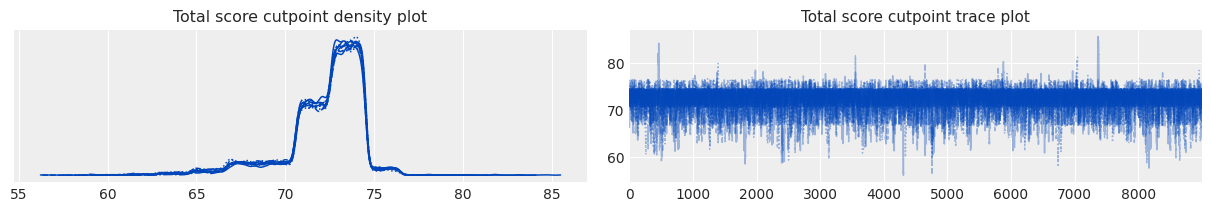

In [ ]:
traceplot(fit, 'Total score cutpoint density plot', 'Total score cutpoint trace plot', 'arviz-bluish')

# Save Model

In [ ]:
import pickle
# fit_types = [fit, fit_erw, fit_math, fit_femtot, fit_erwfem, fit_mathfem, fit_maletot, fit_erwmale, fit_mathmale]

In [ ]:
# with open("gdrive/MyDrive/Thesis_data/model_fit.pkl", "wb") as f:
#     pickle.dump({'fit_newrecode' : fit_types},  f, protocol=-1)
#           #  'data2_arr':data2_arr,
#           #  'data3_arr':data3_arr,
#           #  'data4_arr':data4_arr}, f, protocol=-1)

In [1]:
# with open("gdrive/MyDrive/Thesis_data/model_fit.pkl", "rb") as f:
#   # print(f)
#   # pickle.load(f)
#   data_dict = pickle.load(f)
# fit_types = data_dict['fit_newrecode']


In [ ]:
fit = fit_types[0]
fit_erw = fit_types[1]
fit_math = fit_types[2]
fit_femtot = fit_types[3]
fit_erwfem = fit_types[4]
fit_mathfem = fit_types[5]
fit_maletot = fit_types[6]
fit_erwmale = fit_types[7]
fit_mathmale = fit_types[8]

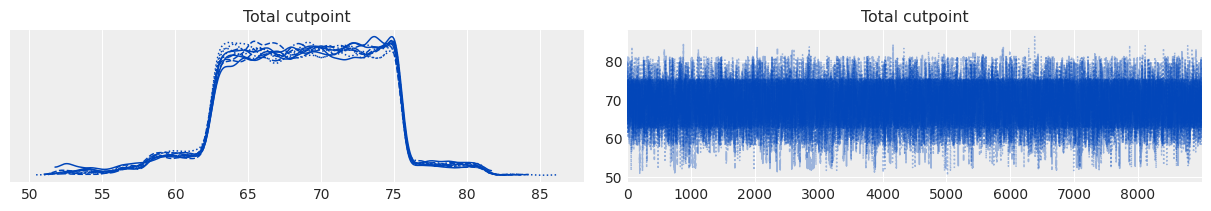

In [ ]:
traceplot(fit, 'Total cutpoint','arviz-bluish')

# HDI, Sensitivity analysis and Posterior predictive check

### HDI

In [ ]:
x = tot_perc2019

In [ ]:
def get_data(fit_type):
  data = az.from_pystan(
      posterior=fit_type,
      posterior_predictive='y_hat',
      observed_data=['y'],
      log_likelihood={"y": "log_lik"},
      coords={"states": np.arange(len(x))},
      dims={
          "mu": ["states"],
          "y": ["states"],
          "log_lik": ["states"],
          "y_hat": ["states"],
          "sigma": ["states"],
      },
  )
  return data

In [ ]:
all_data = []
# fit_types = [fit_mathfem, fit_femtot, fit_math, fit_mathmale, fit_erwfem, fit, fit_maletot, fit_erw, fit_erwmale]
fit_hdi = [fit, fit_femtot, fit_maletot, fit_erw, fit_erwfem, fit_erwmale, fit_math, fit_mathfem, fit_mathmale]
for i in fit_hdi:
  all_data.append(get_data(i))

In [ ]:
# fit_types = [fit, fit_erw, fit_math, fit_femtot, fit_erwfem, fit_mathfem, fit_maletot, fit_erwmale, fit_mathmale]


INFO:numba.core.transforms:finding looplift candidates


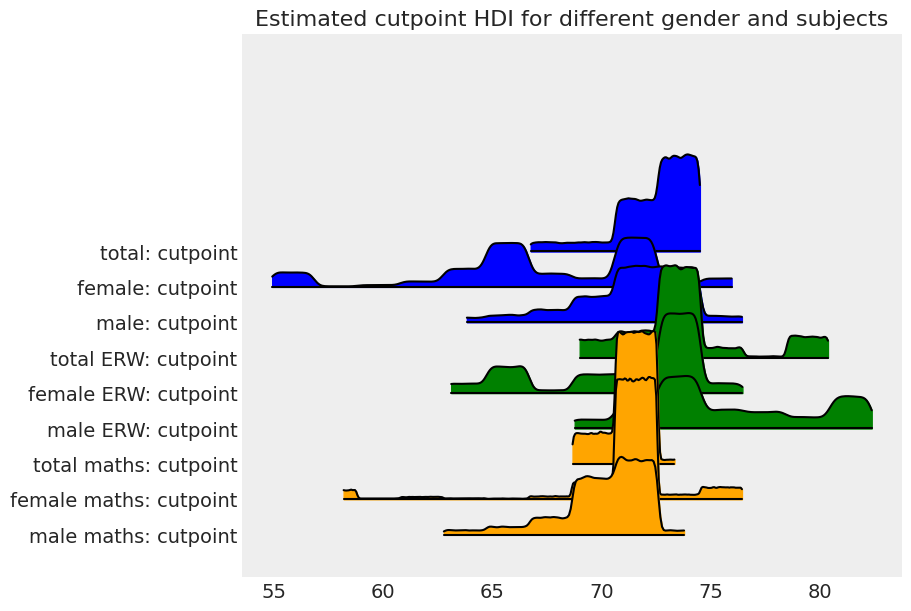

In [ ]:
az.style.use(['arviz-darkgrid', 'arviz-colors'])
axes = az.plot_forest(all_data,
            model_names = ["total", "female", "male", "total ERW", "female ERW", "male ERW", "total maths", "female maths", "male maths"],
            kind='ridgeplot',
            var_names=["cutpoint"],
            labeller=azl.DimCoordLabeller(),
            combined=True,
            legend = False,
            colors = ['blue', 'blue', 'blue', 'green', 'green','green','orange','orange','orange'],
            figsize=(9, 6))
axes[0].set_title('Estimated cutpoint HDI for different gender and subjects');

INFO:numba.core.transforms:finding looplift candidates


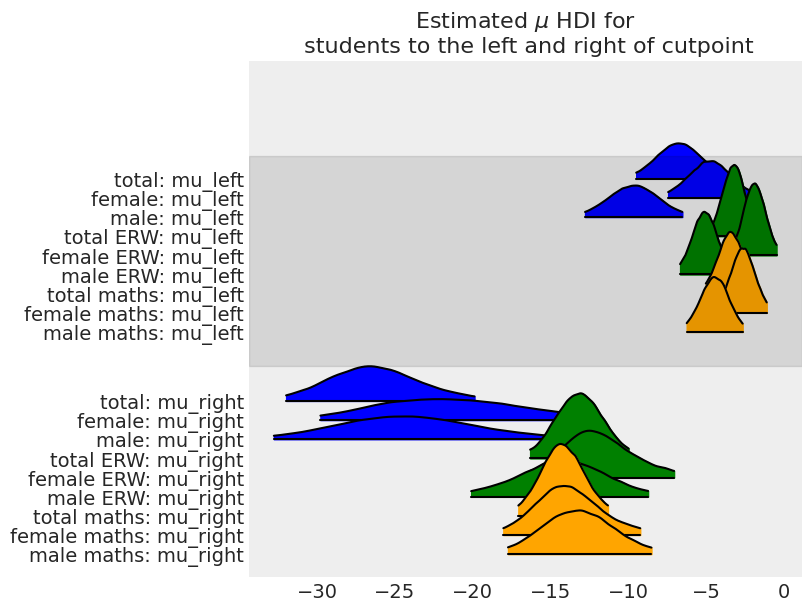

In [ ]:
az.style.use(['arviz-darkgrid', 'arviz-colors'])
# plt.figure(figsize=(3,5))
fig, ax = plt.subplots(1,1,figsize=(8,6))
az.plot_forest(all_data,
            model_names = ["total", "female", "male", "total ERW", "female ERW", "male ERW", "total maths", "female maths", "male maths"],
            kind='ridgeplot',
            var_names=["mu_left","mu_right"],
            labeller=azl.DimCoordLabeller(),
            combined=True,
            legend = False,
            colors = ['blue', 'blue', 'blue', 'green', 'green','green','orange','orange','orange'],ax=ax)

# az.plot_forest(all_data,
#             model_names = ["total", "female", "male", "total ERW", "female ERW", "male ERW", "total maths", "female maths", "male maths"],
#             kind='ridgeplot',
#             var_names=["mu_right"],
#             labeller=azl.DimCoordLabeller(),
#             combined=True,
#             legend = False,
#             colors = ['blue', 'blue', 'blue', 'green', 'green','green','orange','orange','orange'], ax=ax1)
ax.set_title('Estimated $\mu$ HDI for \n students to the left and right of cutpoint');
# ax1.set_title('Estimated $\mu_{right}$ HDI for students to the right of cutpoint');

### Sensitivity analysis

In [ ]:
model_Flower2 = '''
data {
  int<lower=1> n;      
  vector[n] x;
  vector[n] y;
}

parameters {
  real mu_left;
  real mu_right;
  real<lower=0> sigma_left;
  real<lower=0> sigma_right;
  real<lower=50,upper=90> cutpoint;
} 

transformed parameters{
  vector[n] mu; // expected value
  vector[n] sigma; // sd value

  
  for (i in 1:n) {
    if (x[i] < cutpoint) {
      mu[i] = mu_left;
      sigma[i] = sigma_left;
    } else {
      mu[i] = mu_right;
      sigma[i] = sigma_right;
    }
  }
}

model {
  mu_left ~ normal(0, 20);
  mu_right ~ normal(0, 20);
  sigma_left ~ lognormal(5, 3);
  sigma_right ~ lognormal(5, 3);
  cutpoint ~ uniform(50, 90);
  y ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  vector[n] y_hat;
  for (j in 1:n) {
      log_lik[j] = normal_lpdf(y[j] | mu[j], sigma[j]);
      y_hat[j] = normal_rng(mu[j], sigma[j]);
  }
}
'''

In [ ]:
flower2 = pystan.StanModel(model_code=model_Flower2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c7c57f2a86822fa72e88883844b9ce1b NOW.


In [ ]:
model_Flower3 = '''
data {
  int<lower=1> n;      
  vector[n] x;
  vector[n] y;
}

parameters {
  real mu_left;
  real mu_right;
  real<lower=0> sigma_left;
  real<lower=0> sigma_right;
  real<lower=50,upper=90> cutpoint;
} 

transformed parameters{
  vector[n] mu; // expected value
  vector[n] sigma; // sd value

  
  for (i in 1:n) {
    if (x[i] < cutpoint) {
      mu[i] = mu_left;
      sigma[i] = sigma_left;
    } else {
      mu[i] = mu_right;
      sigma[i] = sigma_right;
    }
  }
}

model {
  mu_left ~ normal(0, 10);
  mu_right ~ normal(0, 10);
  sigma_left ~ inv_gamma(2, 300);
  sigma_right ~ inv_gamma(2, 300);
  cutpoint ~ uniform(50, 90);
  y ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  vector[n] y_hat;
  for (j in 1:n) {
      log_lik[j] = normal_lpdf(y[j] | mu[j], sigma[j]);
      y_hat[j] = normal_rng(mu[j], sigma[j]);
  }
}
'''

In [ ]:
flower3 = pystan.StanModel(model_code=model_Flower3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49f04276710595279c148ea370163f67 NOW.


In [ ]:
import matplotlib.patches as mpatches

In [ ]:
model_Flower4 = '''
data {
  int<lower=1> n;      
  vector[n] x;
  vector[n] y;
}

parameters {
  real mu_left;
  real mu_right;
  real<lower=0> sigma_left;
  real<lower=0> sigma_right;
  real<lower=0,upper=100> cutpoint;
} 

transformed parameters{
  vector[n] mu; // expected value
  vector[n] sigma; // sd value

  
  for (i in 1:n) {
    if (x[i] < cutpoint) {
      mu[i] = mu_left;
      sigma[i] = sigma_left;
    } else {
      mu[i] = mu_right;
      sigma[i] = sigma_right;
    }
  }
}

model {
  mu_left ~ normal(0, 10);
  mu_right ~ normal(0, 10);
  sigma_left ~ lognormal(3,2);
  sigma_right ~ lognormal(3,2);;
  cutpoint ~ uniform(0, 100);

  # mu_left ~ normal(-10, 10);
  # mu_right ~ normal(-10, 10);
  # sigma_left ~ inv_gamma(2,600);
  # sigma_right ~ inv_gamma(2,600);
  # cutpoint ~ uniform(50, 90);
  y ~ normal(mu, sigma);
}

generated quantities {
  vector[n] log_lik;
  vector[n] y_hat;
  for (j in 1:n) {
      log_lik[j] = normal_lpdf(y[j] | mu[j], sigma[j]);
      y_hat[j] = normal_rng(mu[j], sigma[j]);
  }
}
'''

In [ ]:
flower4 = pystan.StanModel(model_code=model_Flower4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e8d9c2a0ec1700a93d91c4b466633425 NOW.


In [ ]:
def fit_func(model, iter_num, xdata, ydata):
  x = xdata
  y = ydata
  data = {'n': len(x), 'x': x, 'y': y}
  current_fit = model.sampling(data=data, iter=iter_num, chains=10, warmup=1000, thin=1, seed=2)
  result_data = get_data(current_fit)
  return result_data

In [ ]:
def plot_asubplot(orig_data, data2, data3, data4, ax_pos, title):
  az.plot_density(
      orig_data,
      var_names=["cutpoint"],
      ax=ax_pos, colors='red'
  )
  
  az.plot_density(
      data2,
      var_names=["cutpoint"],
      ax=ax_pos, colors='blue'
  )

  az.plot_density(
      data3,
      var_names=["cutpoint"],
      ax=ax_pos, colors='green'
  )

  az.plot_density(
      data4,
      var_names=["cutpoint"],
      ax=ax_pos, colors='purple'
  )

  import matplotlib.patches as mpatches
  red_patch = mpatches.Patch(color='red', label='model 1 (implemented model)')
  blue_patch = mpatches.Patch(color='blue', label='model 2')
  green_patch = mpatches.Patch(color='green', label='model 3')
  purple_patch = mpatches.Patch(color='purple', label='model 4')
  ax_pos.legend(handles=[red_patch,blue_patch,green_patch,purple_patch],fontsize=10)
  ax_pos.set_title(title)
  ax_pos.set_xlabel('2019 mean score (in percentage)', fontsize=12)

In [ ]:
x = tot_perc2019
y = tot_mean2020-tot_mean2019

In [ ]:
#Data from original model
orig_data_arr = []
fit_types = [fit, fit_erw, fit_math, fit_femtot, fit_erwfem, fit_mathfem, fit_maletot, fit_erwmale, fit_mathmale]

for i in fit_types:
  orig_data_arr.append(get_data(i))
  break

In [ ]:
#Data from model 2
data2_arr = []
data2_arr.append(fit_func(flower2, 10000, x, y))
# x_arr = [tot_perc2019, erw_perc2019, math_perc2019, 
#       tot_fem_perc2019, erw_fem_perc2019, math_fem_perc2019, 
#       tot_male_perc2019, erw_male_perc2019, math_male_perc2019]
# y_arr = [tot_mean2020-tot_mean2019, erw_mean2020-erw_mean2019, math_mean2020-math_mean2019, 
#       tot_fem2020-tot_fem2019, erw_fem2020-erw_fem2019, math_fem2020-math_fem2019, 
#       tot_male2020-tot_male2019, erw_male2020-erw_male2019, math_male2020-math_male2019]

# for i in tqdm(range(len(orig_data_arr))):
# # for i in range(1):
#   data2_arr.append(fit_func(flower2, 10000, x_arr[i], y_arr[i]))

In [ ]:
data3_arr = []
data3_arr.append(fit_func(flower3, 10000, x, y))

In [ ]:
data4_arr = []
data4_arr.append(fit_func(flower4, 10000, x, y))

In [ ]:
# plot_asubplot(orig_data_arr[0], data3_arr[0], axs[0,0], 'Total cutpoint distribution')

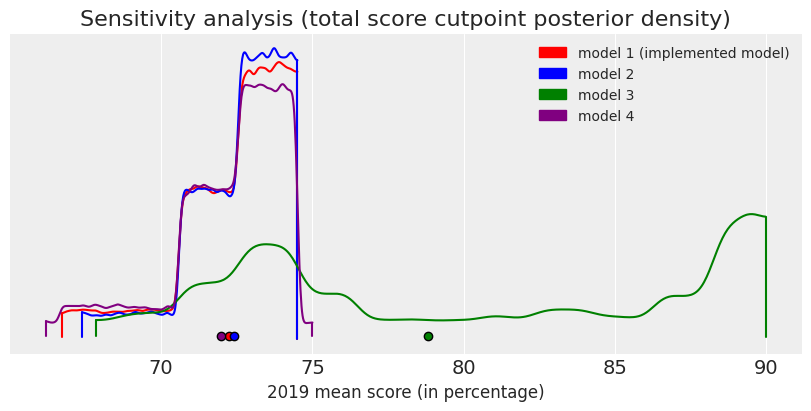

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(8,4))
plot_asubplot(orig_data_arr[0], data2_arr[0], data3_arr[0], data4_arr[0],axs, 'Sensitivity analysis (total score cutpoint posterior density)')
# plot_asubplot(data3_arr[1], axs[0,1], 'ERW cutpoint distribution')
# plot_asubplot(data3_arr[2], axs[0,2], 'Maths cutpoint distribution')
# plot_asubplot(data3_arr[3], axs[1,0], 'Female cutpoint distribution')
# plot_asubplot(data3_arr[4], axs[1,1], 'Female ERW cutpoint distribution')
# plot_asubplot(data3_arr[5], axs[1,2], 'Female maths cutpoint distribution')
# plot_asubplot(data3_arr[6], axs[2,0], 'Male cutpoint distribution')
# plot_asubplot(data3_arr[7], axs[2,1], 'Male ERW cutpoint distribution')
# plot_asubplot(data3_arr[8], axs[2,2], 'Male maths cutpoint distribution')

### Posterior predictive check

In [ ]:
posterior_sample = np.zeros(51)

for i in range(1,52):
  current_y = fit['y_hat['+str(i)+']'][0]
  posterior_sample[i-1] = current_y

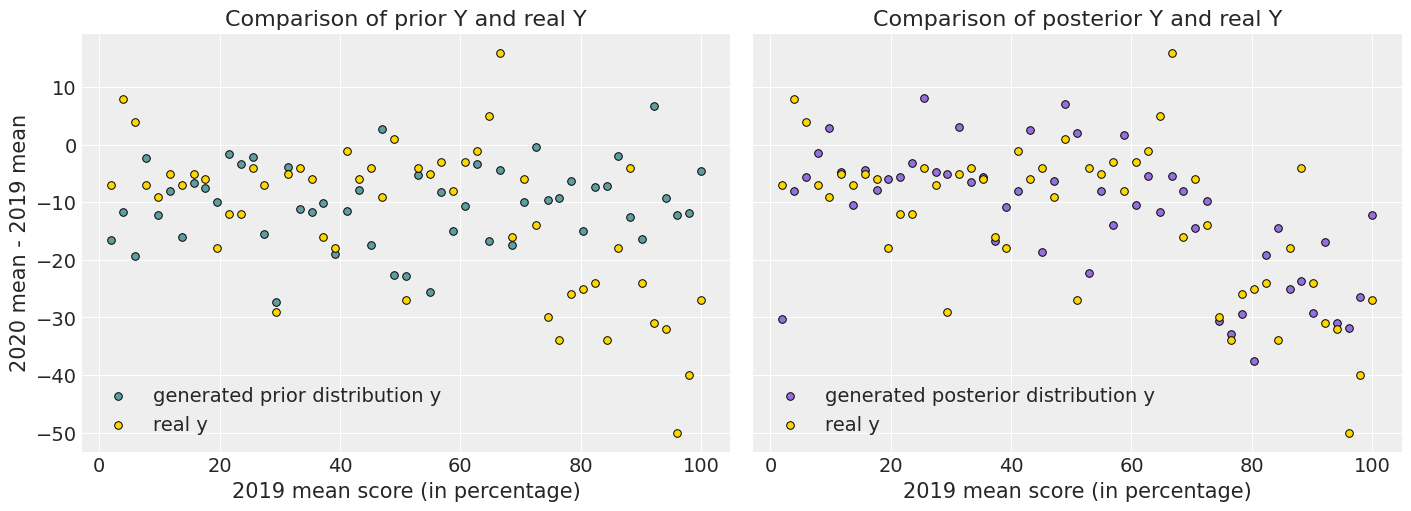

In [ ]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(14,5))
ax0.scatter(tot_perc2019, prior_sample, color='cadetblue', edgecolor='black', s=30, linewidth=0.7, label='generated prior distribution y')
ax0.scatter(tot_perc2019, tot_mean2020-tot_mean2019, color='gold', edgecolor='black', s=30, linewidth=0.7, label='real y')
ax0.legend()
ax0.set_title('Comparison of prior Y and real Y')

ax1.scatter(tot_perc2019, posterior_sample, color='mediumpurple', edgecolor='black', s=30, linewidth=0.7, label='generated posterior distribution y')
ax1.scatter(tot_perc2019, tot_mean2020-tot_mean2019, color='gold', edgecolor='black', s=30, linewidth=0.7, label='real y')
ax1.legend()
ax1.set_title('Comparison of posterior Y and real Y')

for ax in [ax0, ax1]:
    ax.set(xlabel='2019 mean score (in percentage)', ylabel='2020 mean - 2019 mean')
for ax in fig.get_axes():
    ax.label_outer()

# Permutation Test and Bootstrap

In [ ]:
def get_ABgroup(bline, x, y):
    A = []
    B = []
    for i in range(len(x)):
        if x[i] <= bline:
            A.append(y[i])
        else:
            B.append(y[i])
    return A, B

Permutation test

In [ ]:
fit_mean = np.mean(fit['cutpoint'])
fit_erw_mean = np.mean(fit_erw['cutpoint'])
fit_math_mean = np.mean(fit_math['cutpoint'])
fit_femtot_mean = np.mean(fit_femtot['cutpoint'])
fit_erwfem_mean = np.mean(fit_erwfem['cutpoint'])
fit_mathfem_mean = np.mean(fit_mathfem['cutpoint'])
fit_maletot_mean = np.mean(fit_maletot['cutpoint'])
fit_erwmale_mean = np.mean(fit_erwmale['cutpoint'])
fit_mathmale_mean = np.mean(fit_mathmale['cutpoint'])

In [ ]:
from mlxtend.evaluate import permutation_test
def perm_test(cutpoint, x, y, type):
  treatment, control = get_ABgroup(cutpoint, x, y)
  # print(treatment)
  # print(control)
  p_value = permutation_test(treatment, control,
                method='approximate',
                num_rounds=10000)
  print(type+" p-value: ", p_value)

In [ ]:
fit_erw_mean

76.57806493519622

In [ ]:
perm_test(1200, tot_mean2019, tot_mean2020-tot_mean2019, 'Total scores')
perm_test(600, erw_mean2019, erw_mean2020-erw_mean2019, 'Total ERW scores')
perm_test(600, math_mean2019, math_mean2020-math_mean2019, 'Total maths scores')
perm_test(1200, tot_fem2019, tot_fem2020-tot_fem2019, 'Female scores')
perm_test(600, erw_fem2019, erw_fem2020-erw_fem2019, 'Female ERW scores')
perm_test(600, math_fem2019, math_fem2020-math_fem2019, 'Female maths scores')
perm_test(1200, tot_male2019, tot_male2020-tot_male2019, 'Male scores')
perm_test(600, erw_male2019, erw_male2020-tot_male2019, 'Male ERW scores')
perm_test(600, math_male2019, math_male2020-math_male2019, 'Male maths scores')

Total scores p-value:  0.0
Total ERW scores p-value:  0.0
Total maths scores p-value:  0.0
Female scores p-value:  0.0
Female ERW scores p-value:  0.0
Female maths scores p-value:  0.0001
Male scores p-value:  0.0
Male ERW scores p-value:  0.0
Male maths scores p-value:  0.0001


In [ ]:
perm_test(fit_mean, tot_perc2019, tot_mean2020-tot_mean2019, 'Total scores')
perm_test(fit_erw_mean, erw_perc2019, erw_mean2020-erw_mean2019, 'Total ERW scores')
perm_test(fit_math_mean, math_perc2019, math_mean2020-math_mean2019, 'Total maths scores')
perm_test(fit_femtot_mean, tot_fem_perc2019, tot_fem2020-tot_fem2019, 'Female scores')
perm_test(fit_erwfem_mean, erw_fem_perc2019, erw_fem2020-erw_fem2019, 'Female ERW scores')
perm_test(fit_mathfem_mean, math_fem_perc2019, math_fem2020-erw_fem2019, 'Female maths scores')
perm_test(fit_maletot_mean, tot_male_perc2019, tot_male2020-tot_male2019, 'Male scores')
perm_test(fit_erwmale_mean, erw_male_perc2019, erw_male2020-tot_male2019, 'Male ERW scores')
perm_test(fit_mathmale_mean, math_male_perc2019, math_male2020-math_male2019, 'Male maths scores')

Total scores p-value:  0.0
Total ERW scores p-value:  0.0
Total maths scores p-value:  0.0
Female scores p-value:  0.0
Female ERW scores p-value:  0.0
Female maths scores p-value:  0.0272
Male scores p-value:  0.0
Male ERW scores p-value:  0.0
Male maths scores p-value:  0.0


Bootstrapping

In [ ]:
from arch.bootstrap import IndependentSamplesBootstrap

def mean_diff(x, y):
  return x.mean() - y.mean()

def permutation_test(bline, x_data, y_data):
  treatment, control = get_ABgroup(bline, x_data, y_data)
  treatment = np.array(treatment)
  control = np.array(control)

  bs = IndependentSamplesBootstrap(treatment, control, seed=42)
  return bs

In [ ]:
def conf_int(bs):
  return bs.conf_int(mean_diff, method="studentized", reps=5000)

def plot_boot(bs, col_name, ax_pos, col):
  results = bs.apply(mean_diff, 10000)
  diff = pd.DataFrame(results[:, -1:], columns=[col_name])
  # print(diff)
  fig = diff.hist(bins=40, ax=ax_pos, color=col, sharey=True, grid=False)
  ax_pos.axvline(x=np.median(diff[col_name].values), linestyle='--',linewidth=2,color='black', label='median')
  ax_pos.axvline(x=np.quantile(diff[col_name].values, q=0.025), linestyle='dotted',linewidth=2,color='firebrick', label='2.5% quantile')
  ax_pos.axvline(x=np.quantile(diff[col_name].values, q=0.975), linestyle='dotted',linewidth=2,color='firebrick', label='97.5% quantile')
  ax_pos.set_axisbelow(True)
  ax_pos.legend()

Plot the bootstrap results

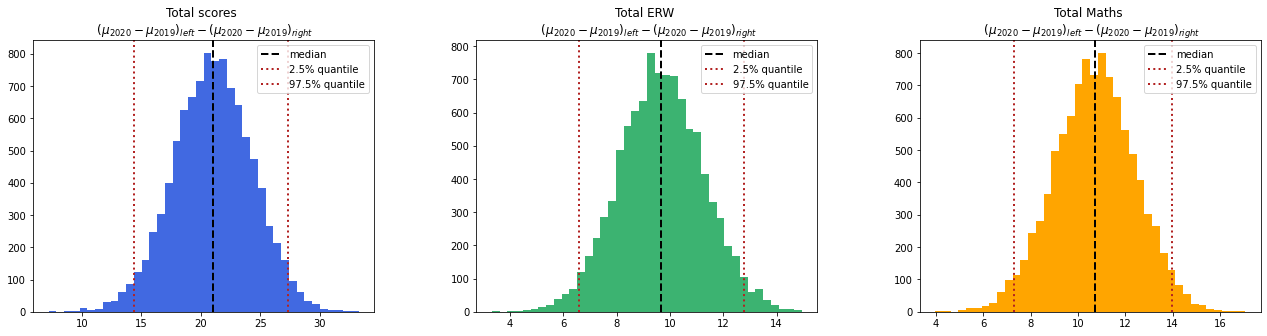

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(22,5))
plot_boot(permutation_test(1200, tot_mean2019, tot_mean2020-tot_mean2019), 'Total scores \n $(\mu_{2020}-\mu_{2019})_{left} - (\mu_{2020}-\mu_{2019})_{right}$', ax[0], 'royalblue')
plot_boot(permutation_test(600, erw_mean2019, erw_mean2020-erw_mean2019), 'Total ERW \n $(\mu_{2020}-\mu_{2019})_{left} - (\mu_{2020}-\mu_{2019})_{right}$', ax[1], 'mediumseagreen')
plot_boot(permutation_test(600, math_mean2019, math_mean2020-math_mean2019), 'Total Maths \n $(\mu_{2020}-\mu_{2019})_{left} - (\mu_{2020}-\mu_{2019})_{right}$', ax[2], 'orange')

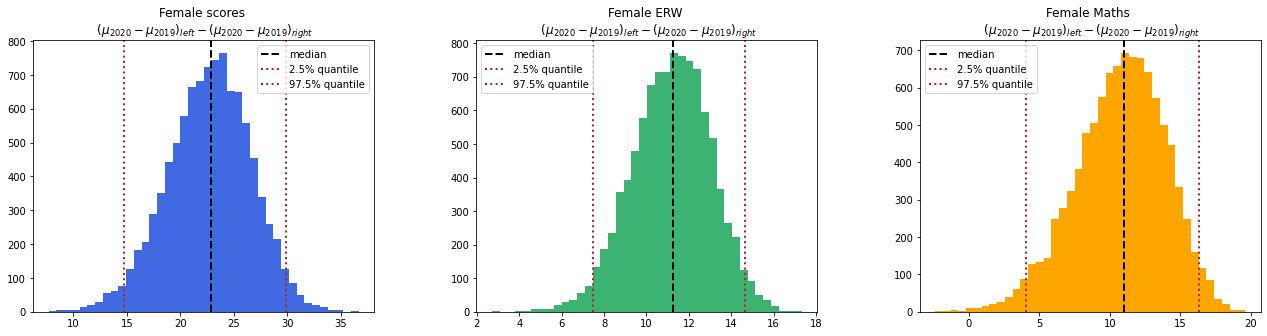

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(22,5))
plot_boot(permutation_test(1200, tot_fem2019, tot_fem2020-tot_fem2019), 'Female scores \n $(\mu_{2020}-\mu_{2019})_{left} - (\mu_{2020}-\mu_{2019})_{right}$', ax[0], 'royalblue')
plot_boot(permutation_test(600, erw_fem2019, erw_fem2020-erw_fem2019), 'Female ERW \n $(\mu_{2020}-\mu_{2019})_{left} - (\mu_{2020}-\mu_{2019})_{right}$', ax[1], 'mediumseagreen')
plot_boot(permutation_test(600, math_fem2019, math_fem2020-math_fem2019), 'Female Maths \n $(\mu_{2020}-\mu_{2019})_{left} - (\mu_{2020}-\mu_{2019})_{right}$', ax[2], 'orange')

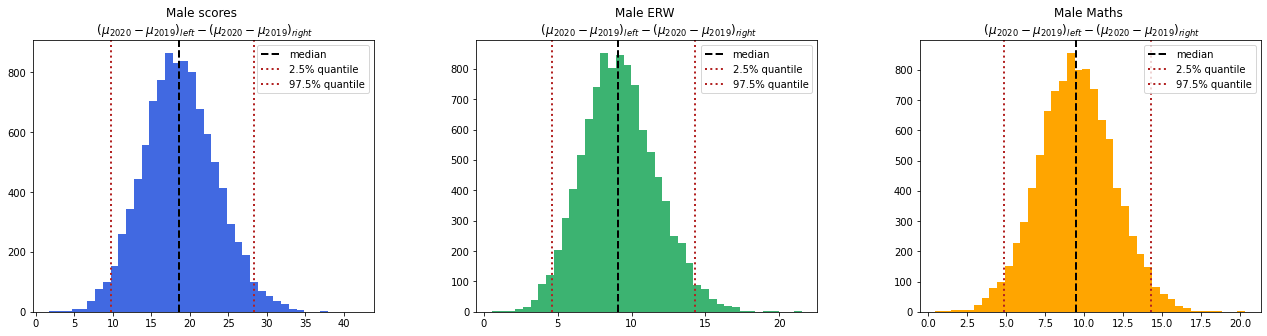

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(22,5))
plot_boot(permutation_test(1200, tot_male2019, tot_male2020-tot_male2019), 'Male scores \n $(\mu_{2020}-\mu_{2019})_{left} - (\mu_{2020}-\mu_{2019})_{right}$', ax[0], 'royalblue')
plot_boot(permutation_test(600, erw_male2019, erw_male2020-erw_male2019), 'Male ERW \n $(\mu_{2020}-\mu_{2019})_{left} - (\mu_{2020}-\mu_{2019})_{right}$', ax[1], 'mediumseagreen')
plot_boot(permutation_test(600, math_male2019, math_male2020-math_male2019), 'Male Maths \n $(\mu_{2020}-\mu_{2019})_{left} - (\mu_{2020}-\mu_{2019})_{right}$', ax[2], 'orange')

Confidence intervals

In [ ]:
print('CI of total students scores: ', conf_int(permutation_test(1200, tot_mean2019, tot_mean2020-tot_mean2019)))
print('CI of total students ERW scores: ', conf_int(permutation_test(600, erw_mean2019, erw_mean2020-erw_mean2019)))
print('CI of total students maths scores: ', conf_int(permutation_test(600, math_mean2019, math_mean2020-math_mean2019)))

CI of total students scores:  [[13.94171241]
 [27.79537475]]
CI of total students ERW scores:  [[ 6.08507158]
 [13.17768623]]
CI of total students maths scores:  [[ 7.09710706]
 [14.23156075]]


In [ ]:
print('CI of female students scores: ', conf_int(permutation_test(1200, tot_fem2019, tot_fem2020-tot_fem2019)))
print('CI of female students ERW scores: ', conf_int(permutation_test(600, erw_fem2019, erw_fem2020-erw_fem2019)))
print('CI of female students maths scores: ', conf_int(permutation_test(600, math_fem2019, math_fem2020-math_fem2019)))

CI of female students scores:  [[12.60470838]
 [29.80145692]]
CI of female students ERW scores:  [[ 6.13634847]
 [14.58327014]]
CI of female students maths scores:  [[ 0.41317913]
 [16.63795677]]


In [ ]:
print('CI of male students scores: ', conf_int(permutation_test(1200, tot_male2019, tot_male2020-tot_male2019)))
print('CI of male students ERW scores: ', conf_int(permutation_test(600, erw_male2019, erw_male2020-erw_male2019)))
print('CI of male students maths scores: ', conf_int(permutation_test(600, math_male2019, math_male2020-math_male2019)))

CI of male students scores:  [[10.18371872]
 [30.42615802]]
CI of male students ERW scores:  [[ 4.79409213]
 [16.06003312]]
CI of male students maths scores:  [[ 4.94189305]
 [14.75011908]]


In [ ]:
data_dict = {}
data_dict['category'] = ['total','female','male', 'total ERW', 'female ERW', 'male ERW', 'total maths', 'female maths', 'male maths']
data_dict['lower'] = [13.77847734, 12.56579525, 10.32513139, 6.08507158,  6.13634847, 4.79409213, 7.09710706, 0.41317913, 4.94189305]
data_dict['upper'] = [27.74473812, 29.84017923, 30.42615802, 13.17768623, 14.58327014, 16.06003312, 14.23156075, 16.63795677, 14.75011908]
dataset = pd.DataFrame(data_dict)

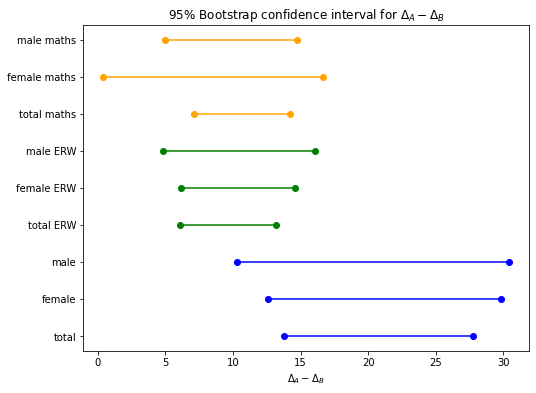

In [ ]:
color_list = ['blue', 'blue', 'blue', 'green', 'green','green','orange','orange','orange']
plt.figure(figsize=(8,6))
for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color=color_list[y])
plt.xlabel('$\Delta_A - \Delta_B$')
plt.title('95% Bootstrap confidence interval for $\Delta_A - \Delta_B$')
plt.yticks(range(len(dataset)),list(dataset['category']));